In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, os, sys, gc

from scipy.integrate import solve_ivp

import class_energy as energy
import class_equations_of_motion as eom 

import class_handle_input as h_in
import class_handle_wavefunctions as h_wavef

import class_visualization as vis
import class_mass_size as mass_size

In [2]:
def plot_rotor_wavefunction(x, chosen_My, chosen_Mx, psi):
    A = 6
    plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
    ##plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    #plt.rc('text.latex', preambler=r'\usepackage{textgreek}')
    font_size = 18 

    fig, axs = plt.subplots(chosen_My,chosen_Mx, subplot_kw=dict(polar=True))
    #plt.suptitle(r'$V_0 =$'+str(V_0), fontsize=font_size)

    for i in range(chosen_My):
         for j in range(chosen_Mx):
            axs[i, j].plot(x, psi[(i+int(chosen_My/2))%chosen_My,(j+int(chosen_My/2))%chosen_My], color='lightcoral')

            axs[i, j].set_yticklabels([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_theta_zero_location('E')

            axs[i, j].grid(linewidth=0.5)
            axs[i, j].spines['polar'].set_linewidth(0.3) #.set_visible(False)

    #axs[0, 0].set_theta_zero_location('E')
    #lines, labels = axs[0, 0].set_thetagrids((0, 45, 90, 135, 180), (r'0', ' ', r'$\pi/2$', ' ', r'$\pi$'))

In [3]:
def solve_imag_time_prop(params):
    Mx = params["Mx"]
    My = params["My"]

    n = params["n"]
    V_0 = params["V_0"]

    wfn_manip = h_wavef.wavefunc_operations(params=params)
    wavefunc_object = h_wavef.wavefunctions(params=params)
    eom_object = eom.eom(params=params) 

    eom_object.V_0 = V_0
    wavefunc_object.V_0 = V_0 

    psi_init = wavefunc_object.create_init_wavefunction(params['init_choice']) # update for small polaron things
    psi_init = wfn_manip.reshape_one_dim(psi_init)
        
    psi_0 = psi_init.copy() # for green function 

    # energy objects
    energy_object = energy.energy(params=params)
    overlap_object = energy.coupling_of_states(params=params) # needed for overlap calculations
        
    energy_object.V_0 = V_0
    overlap_object.V_0 = V_0

    # lambda expression of right-hand-side of e.o.m
    func = eom_object.create_integration_function_imag_time_prop() 

    iter = 0
    epsilon = 1 
    tol = params['tol']
    dt  = params['dt']
    E_converge_list = []
    while epsilon > tol:
        #print('V_0 =', V_0, ', iter step = ' + str(iter+1))
            
        '''
        imag time evolution for dt
        '''
        sol = solve_ivp(func, [0,dt], psi_init, method='RK45', rtol=1e-9, atol=1e-9) # method='RK45','DOP853'

        '''
        normalize
        '''
        psi_iter = sol.y.T[-1]
        psi_iter = wfn_manip.normalize_wf(psi_iter, shape=(int(Mx*My),n))

        '''
        compute and save energy and epsilon criterion
        '''
        E = energy_object.calc_energy(psi_iter)
        E_converge_list.append(E[0].real)
        epsilon = eom_object.epsilon_criterion_single_rotor(psi_iter, psi_init)
        #print("E =", E[0].real, ", epsilon =", epsilon, "\n")

        '''
        update psi_init
        '''
        psi_init = wfn_manip.reshape_one_dim(psi_iter)
        iter = iter + 1

    psi_out = wfn_manip.reshape_three_dim(psi_init)
    
    V_final = energy_object.calc_energy(psi_out)[3]
    dE_dtx, dE_dty = energy_object.deriv_dE_dt(psi_out)
    return psi_out, E_converge_list, V_final, dE_dtx, dE_dty

In [4]:
params = {"n": 256,
"M": 36,
"Mx": 6,
"Mx_display": 4,
"converge_new_lattice": "no",
"My": 6,
"My_display": 4,
"B": 1.0,
"tx": 100,
"ty": 100,
"V_0": 150.0,
"qx": 0,
"qy": 0,
"init_choice": "ferro_domain_vertical_wall",
"external_wf_tag": " ",
"excitation_no": 11,
"angle_pattern": [0,0,0,0],
"V_0_pattern": [150,150,150,150],
"n_states": 0,
"path_to_input_wavefunction": " ",
"dt": 0.001,
"tol": 1e-7}

x = (2*np.pi/params["n"])*np.arange(params["n"])

Mx = params["Mx"]
My = params["My"]

n = params["n"]

tx = params["tx"]
ty = params["ty"]

B = params["B"]
V_0 = params["V_0"]

scale = B 

exc_number = params["excitation_no"]

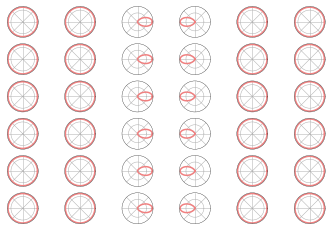

In [5]:
wavefunc_object = h_wavef.wavefunctions(params=params)    
wavefunc_object.V_0 = V_0 

psi_init = wavefunc_object.create_init_wavefunction(params['init_choice']) # update for small polaron things
plot_rotor_wavefunction(x, My, Mx, psi_init.real)

In [6]:
def get_tx_ty(sum, diff):
    tx = 0.5*(sum+diff)
    ty = 0.5*(sum-diff)
    return tx, ty

In [7]:
sum_tx_ty = 200
diff_tx_ty = np.array([-100,-50,-25,-5,0,5,25,50,100])
V_0_arr = np.array([0,25,50,75,100,125,150,175,200,225,250])

In [8]:
for i in diff_tx_ty:
    print(get_tx_ty(sum_tx_ty,i))

(50.0, 150.0)
(75.0, 125.0)
(87.5, 112.5)
(97.5, 102.5)
(100.0, 100.0)
(102.5, 97.5)
(112.5, 87.5)
(125.0, 75.0)
(150.0, 50.0)


V_0 =  0 , tx-ty = -100 , E = -400.0
V_0 =  0 , tx-ty = -50 , E = -400.0
V_0 =  0 , tx-ty = -25 , E = -400.0
V_0 =  0 , tx-ty = -5 , E = -400.0
V_0 =  0 , tx-ty = 0 , E = -400.0
V_0 =  0 , tx-ty = 5 , E = -400.0
V_0 =  0 , tx-ty = 25 , E = -400.0
V_0 =  0 , tx-ty = 50 , E = -400.0
V_0 =  0 , tx-ty = 100 , E = -400.0
V_0 =  25 , tx-ty = -100 , E = -404.41453463111304
V_0 =  25 , tx-ty = -50 , E = -403.9077156061017
V_0 =  25 , tx-ty = -25 , E = -403.80960437690595
V_0 =  25 , tx-ty = -5 , E = -403.7760718772013
V_0 =  25 , tx-ty = 0 , E = -403.77492950579074
V_0 =  25 , tx-ty = 5 , E = -403.7760718772001
V_0 =  25 , tx-ty = 25 , E = -403.80960437690504
V_0 =  25 , tx-ty = 50 , E = -403.90771560610216
V_0 =  25 , tx-ty = 100 , E = -404.41453463111344
V_0 =  50 , tx-ty = -100 , E = -418.035799774989
V_0 =  50 , tx-ty = -50 , E = -415.81087482103334
V_0 =  50 , tx-ty = -25 , E = -415.3828341460772
V_0 =  50 , tx-ty = -5 , E = -415.25363307043824
V_0 =  50 , tx-ty = 0 , E = -415.24858285772

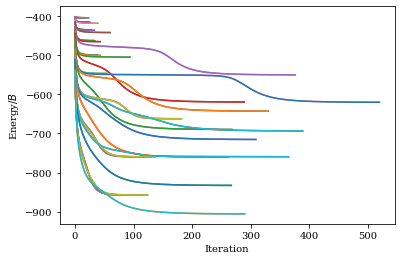

In [9]:
params["init_choice"] = "uniform"

E_fo_arr = np.zeros((len(V_0_arr),len(diff_tx_ty)), dtype=complex)
Tx_fo = np.zeros((len(V_0_arr),len(diff_tx_ty)), dtype=complex)
Ty_fo = np.zeros((len(V_0_arr),len(diff_tx_ty)), dtype=complex)
V_fo  = np.zeros((len(V_0_arr),len(diff_tx_ty)), dtype=complex)
for i in range(len(V_0_arr)):
    for j in range(len(diff_tx_ty)):
        tx, ty = get_tx_ty(sum_tx_ty, diff_tx_ty[j])

        params["tx"] = tx
        params["ty"] = ty
        params["V_0"] = V_0_arr[i]
        
        psi_fo, E_evo_fo, V, dE_dtx, dE_dty = solve_imag_time_prop(params)

        print('V_0 = ', V_0_arr[i], ', tx-ty =', diff_tx_ty[j], ', E =', E_evo_fo[-1])
        plt.plot(E_evo_fo); plt.xlabel(r'Iteration'); plt.ylabel(r'Energy$/B$')
        #plot_rotor_wavefunction(x, My, Mx, psi_fdv.real)

        E_fo_arr[i,j] = E_evo_fo[-1]
        Tx_fo[i,j] = dE_dtx
        Ty_fo[i,j] = dE_dty
        V_fo[i,j] = V

V_0 =  0 , tx-ty = -100 , E = -399.9256174326883
V_0 =  0 , tx-ty = -50 , E = -399.94546868876483
V_0 =  0 , tx-ty = -25 , E = -399.9463811587329
V_0 =  0 , tx-ty = -5 , E = -399.94982528456177
V_0 =  0 , tx-ty = 0 , E = -399.9504408604505
V_0 =  0 , tx-ty = 5 , E = -399.95041791950933
V_0 =  0 , tx-ty = 25 , E = -399.95089212481776
V_0 =  0 , tx-ty = 50 , E = -399.95169563032573
V_0 =  0 , tx-ty = 100 , E = -399.9517274598618
V_0 =  25 , tx-ty = -100 , E = -351.4728161864433
V_0 =  25 , tx-ty = -50 , E = -301.66002943077694
V_0 =  25 , tx-ty = -25 , E = -276.7840309289912
V_0 =  25 , tx-ty = -5 , E = -256.90016643981676
V_0 =  25 , tx-ty = 0 , E = -251.93593948216704
V_0 =  25 , tx-ty = 5 , E = -246.97325386967765
V_0 =  25 , tx-ty = 25 , E = -227.1318071293906
V_0 =  25 , tx-ty = 50 , E = -202.39507952585953
V_0 =  25 , tx-ty = 100 , E = -153.2872290992575
V_0 =  50 , tx-ty = -100 , E = -415.5436645309939
V_0 =  50 , tx-ty = -50 , E = -366.08431763976444
V_0 =  50 , tx-ty = -25 , E =

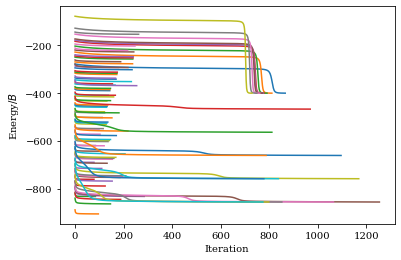

In [10]:
params["init_choice"] = "ferro_domain_vertical_wall"

E_fdv_arr = np.zeros((len(V_0_arr),len(diff_tx_ty)), dtype=complex)
Tx_fdv = np.zeros((len(V_0_arr),len(diff_tx_ty)), dtype=complex)
Ty_fdv = np.zeros((len(V_0_arr),len(diff_tx_ty)), dtype=complex)
V_fdv  = np.zeros((len(V_0_arr),len(diff_tx_ty)), dtype=complex)
for i in range(len(V_0_arr)):
    for j in range(len(diff_tx_ty)):
        tx, ty = get_tx_ty(sum_tx_ty, diff_tx_ty[j])

        params["tx"] = tx
        params["ty"] = ty
        params["V_0"] = V_0_arr[i]
        
        psi_fdv, E_evo_fdv, V, dE_dtx, dE_dty  = solve_imag_time_prop(params)

        print('V_0 = ', V_0_arr[i], ', tx-ty =', diff_tx_ty[j], ', E =', E_evo_fdv[-1])
        plt.plot(E_evo_fdv); plt.xlabel(r'Iteration'); plt.ylabel(r'Energy$/B$')
        #plot_rotor_wavefunction(x, My, Mx, psi_fdv.real)

        E_fdv_arr[i,j] = E_evo_fdv[-1]
        Tx_fdv[i,j] = dE_dtx
        Ty_fdv[i,j] = dE_dty
        V_fdv[i,j] = V

V_0 =  0 , tx-ty = -100 , E = -399.9517274598735
V_0 =  0 , tx-ty = -50 , E = -399.9516956303445
V_0 =  0 , tx-ty = -25 , E = -399.9508921248332
V_0 =  0 , tx-ty = -5 , E = -399.95041791951746
V_0 =  0 , tx-ty = 0 , E = -399.950440860413
V_0 =  0 , tx-ty = 5 , E = -399.94982528456393
V_0 =  0 , tx-ty = 25 , E = -399.9463811587025
V_0 =  0 , tx-ty = 50 , E = -399.9454686888032
V_0 =  0 , tx-ty = 100 , E = -399.9256174327205
V_0 =  25 , tx-ty = -100 , E = -153.2872290992575
V_0 =  25 , tx-ty = -50 , E = -202.3950795258594
V_0 =  25 , tx-ty = -25 , E = -227.131807129391
V_0 =  25 , tx-ty = -5 , E = -246.97325386964118
V_0 =  25 , tx-ty = 0 , E = -251.93593948216713
V_0 =  25 , tx-ty = 5 , E = -256.90016643981664
V_0 =  25 , tx-ty = 25 , E = -276.78403092899146
V_0 =  25 , tx-ty = 50 , E = -301.66002943077723
V_0 =  25 , tx-ty = 100 , E = -351.47281618644405
V_0 =  50 , tx-ty = -100 , E = -220.8845852683683
V_0 =  50 , tx-ty = -50 , E = -268.22357879491216
V_0 =  50 , tx-ty = -25 , E = -29

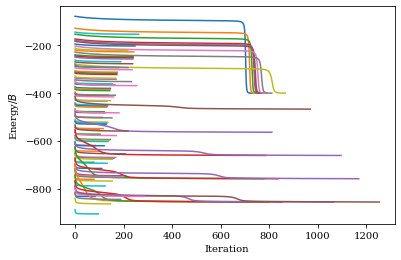

In [11]:
params["init_choice"] = "ferro_domain_horizontal_wall"

E_fdh_arr = np.zeros((len(V_0_arr),len(diff_tx_ty)), dtype=complex)
Tx_fdh = np.zeros((len(V_0_arr),len(diff_tx_ty)), dtype=complex)
Ty_fdh = np.zeros((len(V_0_arr),len(diff_tx_ty)), dtype=complex)
V_fdh  = np.zeros((len(V_0_arr),len(diff_tx_ty)), dtype=complex)
for i in range(len(V_0_arr)):
    for j in range(len(diff_tx_ty)):
        tx, ty = get_tx_ty(sum_tx_ty, diff_tx_ty[j])

        params["tx"] = tx
        params["ty"] = ty
        params["V_0"] = V_0_arr[i]
        
        psi_fdh, E_evo_fdh, V, dE_dtx, dE_dty = solve_imag_time_prop(params)

        print('V_0 = ', V_0_arr[i], ', tx-ty =', diff_tx_ty[j], ', E =', E_evo_fdh[-1])
        plt.plot(E_evo_fdh); plt.xlabel(r'Iteration'); plt.ylabel(r'Energy$/B$')
        #plot_rotor_wavefunction(x, My, Mx, psi_fdv.real)

        E_fdh_arr[i,j] = E_evo_fdh[-1]
        Tx_fdh[i,j] = dE_dtx
        Ty_fdh[i,j] = dE_dty
        V_fdh[i,j] = V

V_0 =  0 , tx-ty = -100 , E = -400.0
V_0 =  0 , tx-ty = -50 , E = -400.0
V_0 =  0 , tx-ty = -25 , E = -400.0
V_0 =  0 , tx-ty = -5 , E = -400.0
V_0 =  0 , tx-ty = 0 , E = -400.0
V_0 =  0 , tx-ty = 5 , E = -400.0
V_0 =  0 , tx-ty = 25 , E = -400.0
V_0 =  0 , tx-ty = 50 , E = -400.0
V_0 =  0 , tx-ty = 100 , E = -400.0
V_0 =  25 , tx-ty = -100 , E = -404.3884819423053
V_0 =  25 , tx-ty = -50 , E = -403.8755423007911
V_0 =  25 , tx-ty = -25 , E = -403.77520849459563
V_0 =  25 , tx-ty = -5 , E = -403.7405731028491
V_0 =  25 , tx-ty = 0 , E = -403.7394605160024
V_0 =  25 , tx-ty = 5 , E = -403.7405731028496
V_0 =  25 , tx-ty = 25 , E = -403.7752084945936
V_0 =  25 , tx-ty = 50 , E = -403.87554230079013
V_0 =  25 , tx-ty = 100 , E = -404.3884819423045
V_0 =  50 , tx-ty = -100 , E = -180.35198024470034
V_0 =  50 , tx-ty = -50 , E = -180.33866760842224
V_0 =  50 , tx-ty = -25 , E = -180.33643429746854
V_0 =  50 , tx-ty = -5 , E = -180.33623879750894
V_0 =  50 , tx-ty = 0 , E = -180.336230652639

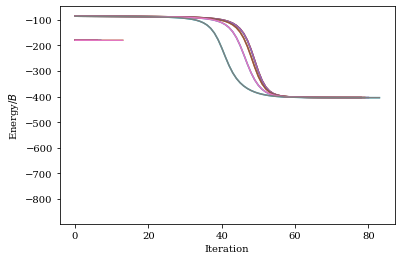

In [12]:
params["init_choice"] = "small_polaron"

E_sp_arr = np.zeros((len(V_0_arr),len(diff_tx_ty)), dtype=complex)
Tx_sp = np.zeros((len(V_0_arr),len(diff_tx_ty)), dtype=complex)
Ty_sp = np.zeros((len(V_0_arr),len(diff_tx_ty)), dtype=complex)
V_sp  = np.zeros((len(V_0_arr),len(diff_tx_ty)), dtype=complex)
for i in range(len(V_0_arr)):
    for j in range(len(diff_tx_ty)):
        tx, ty = get_tx_ty(sum_tx_ty, diff_tx_ty[j])

        params["tx"] = tx
        params["ty"] = ty
        params["V_0"] = V_0_arr[i]
        
        psi_sp, E_evo_sp, V, dE_dtx, dE_dty = solve_imag_time_prop(params)

        print('V_0 = ', V_0_arr[i], ', tx-ty =', diff_tx_ty[j], ', E =', E_evo_sp[-1])
        plt.plot(E_evo_sp); plt.xlabel(r'Iteration'); plt.ylabel(r'Energy$/B$')
        #plot_rotor_wavefunction(x, My, Mx, psi_fdv.real)

        E_sp_arr[i,j] = E_evo_sp[-1]
        Tx_sp[i,j] = dE_dtx
        Ty_sp[i,j] = dE_dty
        V_sp[i,j] = V

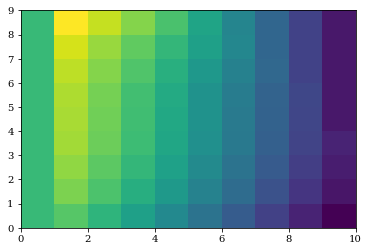

In [13]:
plt.pcolormesh(E_fdv_arr.T.real)

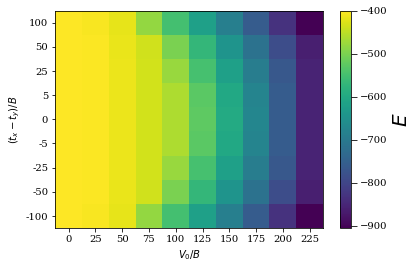

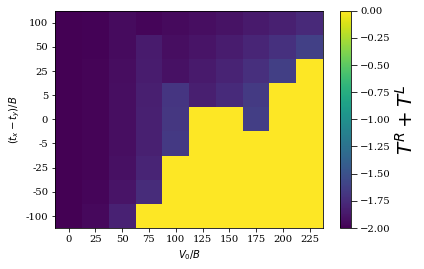

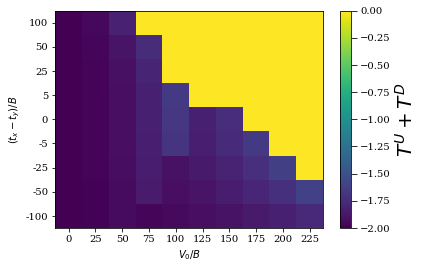

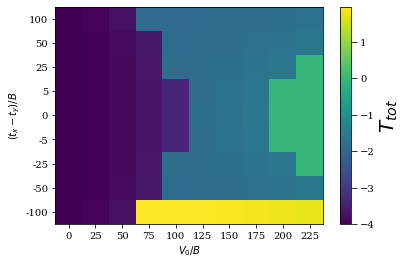

In [78]:
state_no = 0

E_gs = np.zeros(E_fo_arr.shape, dtype=complex)
Tx_order = np.zeros(E_fo_arr.shape, dtype=complex)
Ty_order = np.zeros(E_fo_arr.shape, dtype=complex)

order_p = np.zeros(E_fo_arr.shape, dtype=complex)

for i in range(len(V_0_arr)):
    for j in range(len(diff_tx_ty)):
        E_fo  = E_fo_arr[i,j]
        E_fdv = E_fdv_arr[i,j]
        E_fdh = E_fdh_arr[i,j]
        E_sp  = E_sp_arr[i,j]

        Tx_fo_s  = Tx_fo[i,j]
        Tx_fdv_s = Tx_fdv[i,j]
        Tx_fdh_s = Tx_fdh[i,j]
        Tx_sp_s  = Tx_sp[i,j]

        Ty_fo_s  = Ty_fo[i,j]
        Ty_fdv_s = Ty_fdv[i,j]
        Ty_fdh_s = Ty_fdh[i,j]
        Ty_sp_s  = Ty_sp[i,j]

        E_arr  = np.array([E_fo,E_fdv,E_fdh,E_sp])
        Tx_arr = np.array([Tx_fo_s,Tx_fdv_s,Tx_fdh_s,Tx_sp_s])
        Ty_arr = np.array([Ty_fo_s,Ty_fdv_s,Ty_fdh_s,Ty_sp_s])

        E_index = np.argsort(E_arr)

        E_arr  = E_arr[E_index]
        Tx_arr = Tx_arr[E_index]
        Ty_arr = Ty_arr[E_index]
        
        E_gs[i,j] = E_arr[state_no]
        Tx_order[i,j] = Tx_arr[state_no]
        Ty_order[i,j] = Ty_arr[state_no]
        
        order_p[i,j] = Tx_arr[state_no] + Ty_arr[state_no]
        if E_fdv == np.min(E_arr) and E_fdv < E_fdh:
            order_p[i,j] = -order_p[i,j]
        elif E_fdh == np.min(E_arr) and E_fdh < E_fdv:
            order_p[i,j] = order_p[i,j]
        
fig = plt.figure()
pc = plt.pcolormesh(E_gs.T.real)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(length=6)
cbar.set_label(label=r'$E$', size=20)

plt.xticks(np.arange(len(V_0_arr))+0.5, V_0_arr)
plt.yticks(np.arange(len(diff_tx_ty))+0.5, diff_tx_ty)
plt.xlabel(r'$V_0/B$')
plt.ylabel(r'$(t_x-t_y)/B$')

plt.show()

fig = plt.figure()
pc = plt.pcolormesh(Tx_order.T.real)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(length=6)
cbar.set_label(label=r'$T^R+T^L$', size=20)

plt.xticks(np.arange(len(V_0_arr))+0.5, V_0_arr)
plt.yticks(np.arange(len(diff_tx_ty))+0.5, diff_tx_ty)
plt.xlabel(r'$V_0/B$')
plt.ylabel(r'$(t_x-t_y)/B$')

plt.show()

fig = plt.figure()
pc = plt.pcolormesh(Ty_order.T.real)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(length=6)
cbar.set_label(label=r'$T^U+T^D$', size=20)

plt.xticks(np.arange(len(V_0_arr))+0.5, V_0_arr)
plt.yticks(np.arange(len(diff_tx_ty))+0.5, diff_tx_ty)
plt.xlabel(r'$V_0/B$')
plt.ylabel(r'$(t_x-t_y)/B$')

plt.show()

fig = plt.figure()
pc = plt.pcolormesh(order_p.T.real)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(length=6)
cbar.set_label(label=r'$T_{tot}$', size=20)

plt.xticks(np.arange(len(V_0_arr))+0.5, V_0_arr)
plt.yticks(np.arange(len(diff_tx_ty))+0.5, diff_tx_ty)
plt.xlabel(r'$V_0/B$')
plt.ylabel(r'$(t_x-t_y)/B$')

plt.savefig('phase_diagram.svg')
plt.show()

In [66]:
plt.pcolormesh(E_gs.T.real); plt.show()

0


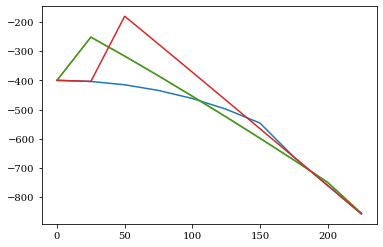

In [57]:
symmetry_index = 4

print(diff_tx_ty[symmetry_index])

%matplotlib inlinecbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=20, length=6)
cbar.set_label(label=r'$\hat{H}_{eff}$', size=20)
plt.plot(V_0_arr, E_fo_arr.T[symmetry_index])
plt.plot(V_0_arr, E_fdv_arr.T[symmetry_index])
plt.plot(V_0_arr, E_fdh_arr.T[symmetry_index])
plt.plot(V_0_arr, E_sp_arr.T[symmetry_index])

#plt.plot(V_0_arr, E_gs.T[0])

In [60]:
print(E_fdv_arr.T[symmetry_index] - E_fdh_arr.T[symmetry_index])
print(Tx_order.T[symmetry_index] - Ty_order.T[symmetry_index])

[-3.75166564e-11+0.j  8.52651283e-14+0.j  3.80850906e-11+0.j
 -3.75166564e-11+0.j -7.38964445e-13+0.j -3.78577170e-11+0.j
 -4.10409484e-11+0.j  7.95807864e-13+0.j  4.04725142e-11+0.j
 -1.36424205e-12+0.j]
[ 0.00000000e+00+0.00000000e+00j -1.77635684e-15-1.73333695e-33j
  4.21884749e-15+2.64815367e-33j  4.44089210e-16+2.50370893e-32j
 -5.99520433e-15-6.35556882e-33j  1.82659951e+00-1.67632942e-30j
  1.74683332e+00-2.76101317e-30j -1.63555818e+00+1.02634165e-48j
  2.01170325e-21-7.80601717e-40j  9.26442286e-22-5.14278778e-39j]


In [62]:
x = np.array([3, 1, 2])
index = np.argsort(x)

x[index]

array([1, 2, 3])